In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import scipy.spatial as sp, scipy.cluster.hierarchy as hc
from scipy.cluster import hierarchy
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.cluster import AgglomerativeClustering

In [2]:
prod_info = pd.read_csv("Data/prod_cat_info.csv")
prod_info.head()

,prod_cat_code,prod_cat,prod_sub_cat_code,prod_subcat
0,1,Clothing,4,Mens
1,1,Clothing,1,Women
2,1,Clothing,3,Kids
3,2,Footwear,1,Mens
4,2,Footwear,3,Women


In [3]:
trans = pd.read_csv("Data/Transactions.csv")
trans.head()

,transaction_id,cust_id,tran_date,prod_subcat_code,prod_cat_code,Qty,Rate,Tax,total_amt,Store_type
0,80712190438,270351,28-02-2014,1,1,-5,-772,405.300,-4265.300,e-Shop
1,29258453508,270384,27-02-2014,5,3,-5,-1497,785.925,-8270.925,e-Shop
2,51750724947,273420,24-02-2014,6,5,-2,-791,166.110,-1748.110,TeleShop
3,93274880719,271509,24-02-2014,11,6,-3,-1363,429.345,-4518.345,e-Shop
4,51750724947,273420,23-02-2014,6,5,-2,-791,166.110,-1748.110,TeleShop


In [4]:
print("We have {:,} transactions total".format(len(trans)))

We have 23,053 transactions total


In [5]:
data = pd.merge(trans, prod_info, how='left', left_on=['prod_cat_code', 'prod_subcat_code'], right_on=['prod_cat_code', 'prod_sub_cat_code'])
data.head()

,transaction_id,cust_id,tran_date,prod_subcat_code,prod_cat_code,Qty,Rate,Tax,total_amt,Store_type,prod_cat,prod_sub_cat_code,prod_subcat
0,80712190438,270351,28-02-2014,1,1,-5,-772,405.300,-4265.300,e-Shop,Clothing,1,Women
1,29258453508,270384,27-02-2014,5,3,-5,-1497,785.925,-8270.925,e-Shop,Electronics,5,Computers
2,51750724947,273420,24-02-2014,6,5,-2,-791,166.110,-1748.110,TeleShop,Books,6,DIY
3,93274880719,271509,24-02-2014,11,6,-3,-1363,429.345,-4518.345,e-Shop,Home and kitchen,11,Bath
4,51750724947,273420,23-02-2014,6,5,-2,-791,166.110,-1748.110,TeleShop,Books,6,DIY


In [6]:
print("We have {:,} transactions total".format(len(data)))
print("We have data from the period between {} and {}".format(min(data['tran_date']), max(data['tran_date'])))
print("Total {} rows of data".format(len(data)))
print("Total {} distinct customers".format(len(set(data['cust_id']))))

We have 23,053 transactions total
We have data from the period between 1/1/2012 and 9/9/2013
Total 23053 rows of data
Total 5506 distinct customers


In [7]:
data['cat'] = data['prod_cat'] + "_" + data['prod_subcat']
data = data[['cust_id', 'cat']]
data.head()

,cust_id,cat
0,270351,Clothing_Women
1,270384,Electronics_Computers
2,273420,Books_DIY
3,271509,Home and kitchen_Bath
4,273420,Books_DIY


In [8]:
print("Total {} distinct products".format(len(set(data['cat']))))

Total 23 distinct products


In [9]:
# We only want to know whether a customer has purchased a particular product within window, no need to keep multiple entries
agg_data = data[['cust_id', 'cat']].drop_duplicates()
print("Total {} rows of data".format(len(agg_data)))
print("Total {} distinct customers".format(len(set(agg_data['cust_id']))))
print("Total {} distinct products".format(len(set(agg_data['cat']))))

Total 19279 rows of data
Total 5506 distinct customers
Total 23 distinct products


In [10]:
# Now we do a quick count to see what are the most/least popular products
prod_count = agg_data[['cat', 'cust_id']].groupby(['cat'])['cust_id'] \
                    .count() \
                    .reset_index(name='count') \
                    .sort_values(['count'], ascending=False)
print("Top selling: {}".format(prod_count['cat'].iloc[0]))
print("Worst selling: {}".format(prod_count['cat'].iloc[len(prod_count)-1]))

Top selling: Home and kitchen_Tools
Worst selling: Footwear_Mens


In [11]:
# Check out the cutoffs for top and bottom 5%, this might be useful later for getting a gaussian curve for dissimilarity density
prod_count['count'].dropna().quantile([0.05, 0.95])

0.05    799.1
0.95    875.7
Name: count, dtype: float64

In [12]:
prod_list = agg_data
prod_list['purchase'] = 1

prod_list_pivot = prod_list.pivot(values='purchase', index='cust_id', columns='cat')
df = prod_list_pivot.reset_index().drop(columns = ['cust_id']).fillna(0).astype(int)

df.head()

cat,Bags_Mens,Bags_Women,Books_Academic,Books_Children,Books_Comics,Books_DIY,Books_Fiction,Books_Non-Fiction,Clothing_Kids,Clothing_Mens,...,Electronics_Computers,Electronics_Mobiles,Electronics_Personal Appliances,Footwear_Kids,Footwear_Mens,Footwear_Women,Home and kitchen_Bath,Home and kitchen_Furnishing,Home and kitchen_Kitchen,Home and kitchen_Tools
0,0,0,0,0,0,0,0,1,0,1,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,1,1,0,0,...,0,1,0,0,0,0,0,0,0,0
2,1,0,0,1,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,1,0
3,1,0,0,0,0,0,1,0,0,0,...,0,0,0,1,1,0,0,0,0,0
4,1,1,1,1,0,0,0,0,1,0,...,0,0,1,0,0,1,0,0,0,0


In [13]:
dm = pairwise_distances(df.T.values, metric = 'yule')
dm = pd.DataFrame(dm, index = df.columns, columns = df.columns)
dm.head()

C:\Users\Leslie\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1735: DataConversionWarning: Data was converted to boolean for metric yule
  warnings.warn(msg, DataConversionWarning)


cat,Bags_Mens,Bags_Women,Books_Academic,Books_Children,Books_Comics,Books_DIY,Books_Fiction,Books_Non-Fiction,Clothing_Kids,Clothing_Mens,...,Electronics_Computers,Electronics_Mobiles,Electronics_Personal Appliances,Footwear_Kids,Footwear_Mens,Footwear_Women,Home and kitchen_Bath,Home and kitchen_Furnishing,Home and kitchen_Kitchen,Home and kitchen_Tools
cat,,,,,,,,,,,,,,,,,,,,,
Bags_Mens,0.000000,0.950031,1.037193,1.117398,1.044798,1.024439,1.031580,1.070689,1.029606,1.098162,...,1.076107,1.001464,1.148232,1.072228,1.033758,1.014892,0.977554,0.941678,0.959320,1.095658
Bags_Women,0.950031,0.000000,1.006547,1.018129,0.960340,1.056767,1.028508,1.057788,1.051207,1.061433,...,0.964723,0.981348,1.026835,1.065114,1.094881,1.000342,1.063006,1.143321,1.059580,1.197426
Books_Academic,1.037193,1.006547,0.000000,1.050848,0.990264,0.926789,0.924628,0.890710,1.044528,1.099551,...,1.101353,0.926777,0.957338,1.023119,1.050835,0.944927,1.021370,1.028001,1.076420,0.980788
Books_Children,1.117398,1.018129,1.050848,0.000000,1.080804,0.908449,0.977297,0.963642,1.021052,1.099316,...,0.955263,1.025956,0.961198,1.068711,0.886027,1.044854,1.017964,0.991832,1.052964,1.126264
Books_Comics,1.044798,0.960340,0.990264,1.080804,0.000000,1.034345,1.030955,0.949856,1.073494,0.964075,...,0.994309,1.011891,1.044122,1.098995,1.037411,1.057270,1.035741,0.937322,0.995654,1.088591


C:\Users\Leslie\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1735: DataConversionWarning: Data was converted to boolean for metric yule
  warnings.warn(msg, DataConversionWarning)


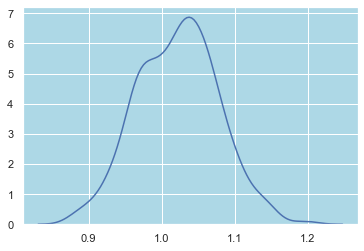

In [14]:
# Here we visualise our disimilarity matrix density, note that we need this to be gaussian for good clustering results
dm_plot = pairwise_distances(df.T.values, metric = "yule")

sns.set(rc={'axes.facecolor':'lightblue', 'figure.facecolor':'white'})
sns.kdeplot(dm_plot[(dm_plot>0) & (dm_plot<2)].flatten())

C:\Users\Leslie\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  This is separate from the ipykernel package so we can avoid doing imports until


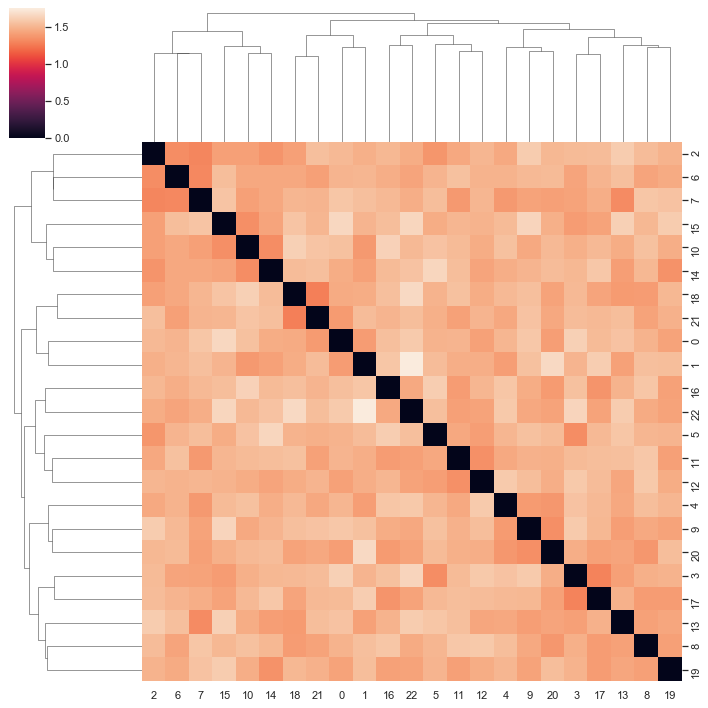

In [15]:
dm2 = pairwise_distances(dm.values, metric = 'euclidean')

linkage = hc.linkage(dm2, method = 'ward')
sns.clustermap(dm2, row_linkage = linkage, col_linkage = linkage)

C:\Users\Leslie\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  """Entry point for launching an IPython kernel.


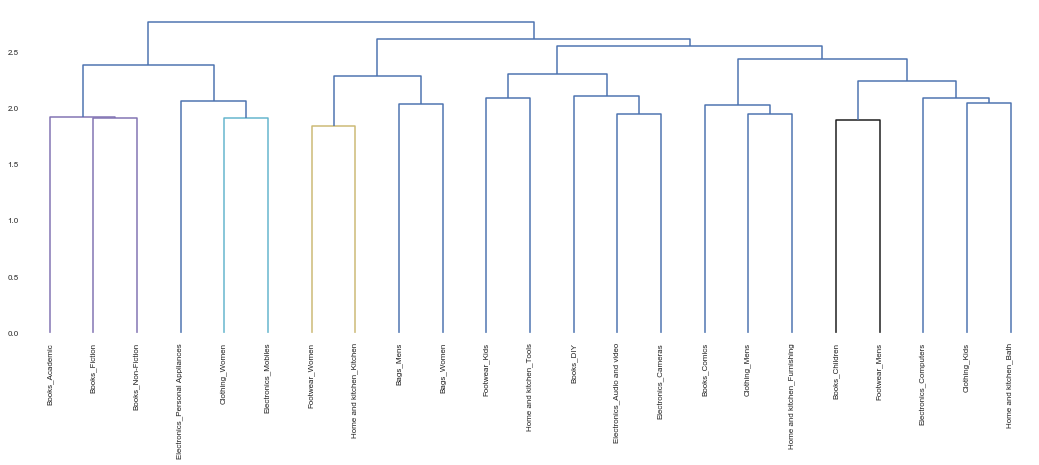

In [16]:
z = hierarchy.linkage(dm2, 'ward')

hierarchy.set_link_color_palette(['m', 'c', 'y', 'k'])
fig, axes = plt.subplots(1, 1, figsize=(18, 6))
axes.set_facecolor('white')
dd = hierarchy.dendrogram(z, ax=axes, leaf_rotation=90, truncate_mode='level', leaf_font_size=8, labels=dm.index)
hierarchy.set_link_color_palette(None)
axes.tick_params(axis="x", labelsize=8)
axes.tick_params(axis='y', labelsize=8)
plt.show()

In [17]:
model = AgglomerativeClustering(affinity='euclidean', linkage='ward', memory=None, n_clusters=5)
model.fit(dm)

labels = model.labels_
labels = pd.DataFrame(data = labels)

dm2 = dm.reset_index()
labels2 = labels.rename(columns={"index":"index", 0:"cluster"})
labels2 = labels2.reset_index()

C:\Users\Leslie\AppData\Roaming\Python\Python37\site-packages\scipy\cluster\hierarchy.py:830: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


In [18]:
clusters = pd.concat([dm2, labels2], axis = 1)
clusters.head()

,cat,Bags_Mens,Bags_Women,Books_Academic,Books_Children,Books_Comics,Books_DIY,Books_Fiction,Books_Non-Fiction,Clothing_Kids,...,Electronics_Personal Appliances,Footwear_Kids,Footwear_Mens,Footwear_Women,Home and kitchen_Bath,Home and kitchen_Furnishing,Home and kitchen_Kitchen,Home and kitchen_Tools,index,cluster
0,Bags_Mens,0.000000,0.950031,1.037193,1.117398,1.044798,1.024439,1.031580,1.070689,1.029606,...,1.148232,1.072228,1.033758,1.014892,0.977554,0.941678,0.959320,1.095658,0,1
1,Bags_Women,0.950031,0.000000,1.006547,1.018129,0.960340,1.056767,1.028508,1.057788,1.051207,...,1.026835,1.065114,1.094881,1.000342,1.063006,1.143321,1.059580,1.197426,1,1
2,Books_Academic,1.037193,1.006547,0.000000,1.050848,0.990264,0.926789,0.924628,0.890710,1.044528,...,0.957338,1.023119,1.050835,0.944927,1.021370,1.028001,1.076420,0.980788,2,0
3,Books_Children,1.117398,1.018129,1.050848,0.000000,1.080804,0.908449,0.977297,0.963642,1.021052,...,0.961198,1.068711,0.886027,1.044854,1.017964,0.991832,1.052964,1.126264,3,3
4,Books_Comics,1.044798,0.960340,0.990264,1.080804,0.000000,1.034345,1.030955,0.949856,1.073494,...,1.044122,1.098995,1.037411,1.057270,1.035741,0.937322,0.995654,1.088591,4,4


In [19]:
list(clusters[clusters.cluster == 0].cat)

['Books_Academic',
 'Books_Fiction',
 'Books_Non-Fiction',
 'Clothing_Women',
 'Electronics_Mobiles',
 'Electronics_Personal Appliances']

In [20]:
list(clusters[clusters.cluster == 1].cat)

['Bags_Mens', 'Bags_Women', 'Footwear_Women', 'Home and kitchen_Kitchen']

In [21]:
list(clusters[clusters.cluster == 2].cat)

['Electronics_Audio and video',
 'Electronics_Cameras',
 'Footwear_Kids',
 'Home and kitchen_Tools']

In [22]:
list(clusters[clusters.cluster == 3].cat)

['Books_Children', 'Books_DIY', 'Footwear_Mens']

In [23]:
list(clusters[clusters.cluster == 4].cat)

['Books_Comics',
 'Clothing_Kids',
 'Clothing_Mens',
 'Electronics_Computers',
 'Home and kitchen_Bath',
 'Home and kitchen_Furnishing']